<a href="https://colab.research.google.com/github/Anirudh2465/Cancer-Prediction-using-Multi-Omics-Data/blob/main/FINAL_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.3.0
!pip install imbalanced-learn==0.11.0
!pip install torch torchvision torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.4
    Uninstalling imbalanced-learn-0.12.4:
      Successfully uninstalled imbalanced-learn-0.12.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import torch
import os
from imblearn.over_sampling import SMOTE

In [ ]:
def load_datas(list_of_files):
  trans_data1=[]
  geno_data1=[]
  prote_data1=[]
  trans_data = pd.DataFrame()
  prote_data = pd.DataFrame()
  geno_data = pd.DataFrame()
  for i in list_of_files:
    if 'prote' in i:
      prote_data1.append(i)
    elif 'trans' in i:
      trans_data1.append(i)
    elif 'geno' in i:
      geno_data1.append(i)

  for j in trans_data1:
    trans_df=pd.read_csv(j,sep='\t')
    trans_data = pd.concat([trans_data,trans_df])
  for j in prote_data1:
    prote_df=pd.read_csv(j,sep='\t')
    prote_data = pd.concat([prote_data,prote_df])
  for j in geno_data1:
    geno_df=pd.read_csv(j,sep='\t')
    geno_data = pd.concat([geno_data,geno_df])
  return trans_data,prote_data,geno_data

In [ ]:
def canornot():
  can = []
  notcan = []
  for file_name in os.listdir('/content/drive/MyDrive/Cancerous'):
    if file_name.endswith('.tsv'):
      can.append(os.path.join('/content/drive/MyDrive/Cancerous', file_name))
  for file_name in os.listdir('/content/drive/MyDrive/Non-Cancerous'):
    if file_name.endswith('.tsv'):
      notcan.append(os.path.join('/content/drive/MyDrive/Non-Cancerous', file_name))
  return can,notcan

In [ ]:
def pre_process(trans_data,prote_data,geno_data,canval):
  mgt = pd.merge(geno_data, trans_data, on='gene_id', how='inner')
  ma = pd.merge(mgt, prote_data,left_on='gene_name_x', right_on='peptide_target', how='inner')
  columns=['Unnamed: 9','Unnamed: 10','gene_name_y','set_id','catalog_number','lab_id','AGID','stranded_first','stranded_second','unstranded','gene_id','start','end','min_copy_number','max_copy_number','gene_type','unstranded']
  for i in columns:
    try:
      ma = ma.drop(columns=[i])
    except:
      pass
  ma.to_csv('all_data.csv', index=False)
  all_data_cleaned = pd.read_csv('all_data.csv')



  # Encode peptide_target into numerical labels
  label_encoder = LabelEncoder()
  all_data_cleaned['gene_name'] = label_encoder.fit_transform(all_data_cleaned['gene_name_x'])
  all_data_cleaned['chromosome'] = label_encoder.fit_transform(all_data_cleaned['chromosome'])
  all_data_cleaned['peptide_target'] = label_encoder.fit_transform(all_data_cleaned['peptide_target'])
  # Prepare node features (protein expression)
  node_features = torch.tensor(all_data_cleaned['protein_expression'].values, dtype=torch.float).unsqueeze(1)

  # Create labels: 1 for cancerous, 0 for non-cancerous
  all_data_cleaned['gene_presence'] = canval

  num_cancerous = all_data_cleaned[all_data_cleaned['gene_presence'] == 1].shape[0]
  labels = torch.tensor([1] * num_cancerous + [0] * (all_data_cleaned.shape[0] - num_cancerous), dtype=torch.float)
  # Check combined data and labels
  all_data_cleaned = all_data_cleaned.drop(columns=['gene_name_x'])
  all_data_cleaned = all_data_cleaned.dropna()
  return all_data_cleaned,labels

In [ ]:
def define_gene_presence(all_data_cleaned):
  # Access the specific column you want to compare
  # Assuming 'gene_presence' or a similar column exists in your data
  if all_data_cleaned['gene_presence'] == 1: # Modified line
    return 1
  else:
    return 0

In [ ]:
def scale_train_split(all_data_cleaned):

  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']]
  target = all_data_cleaned['gene_presence']
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)
  X,y = features_scaled,target
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # use .values to avoid warnings
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
  return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

In [ ]:
def GAT_pre_process(all_data_cleaned):
  all_data_cleaned['gene_presence'] = all_data_cleaned.apply(define_gene_presence, axis=1)
  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']].fillna(0)
  correlation_matrix = features.corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
  plt.title("Correlation Matrix")
  plt.show()


  threshold = 0.8
  edges = []
  edge_attributes = []

    # Step 5: Iterate over the correlation matrix and create edges/attributes
  for i in range(len(correlation_matrix.columns)):
      for j in range(i):
          corr_value = correlation_matrix.iloc[i, j]
          if abs(corr_value) > threshold:
              # Add edge between nodes (i, j) and save the absolute correlation as the edge attribute (weight)
              edges.append([features.columns.get_loc(correlation_matrix.columns[i]),
                            features.columns.get_loc(correlation_matrix.columns[j])])
              edge_attributes.append(abs(corr_value))  # Use the absolute correlation value as the weight

    # Convert edge_index and edge_attributes to numpy arrays
  edge_index = np.array(edges).T  # Shape [2, num_edges]
  edge_attributes = np.array(edge_attributes)  # Shape [num_edges]

  print("Edge Index:")
  print(edge_index)
  print("Edge Attributes (Weights):")
  print(edge_attributes)

  return edge_index, edge_attributes

In [ ]:
can,cannot = canornot()
cantrans,canprote,cangeno = load_datas(can)
notcantrans,notcanprote,notcangeno = load_datas(cannot)

In [ ]:
allcan,canlab = pre_process(cantrans,canprote,cangeno,1)
allnotcan,notcanlab = pre_process(notcantrans,notcanprote,notcangeno,0)

In [ ]:
all_data_cleaned = pd.concat([allcan,allnotcan])
labels = torch.cat((canlab,notcanlab), dim=0)

In [ ]:
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = scale_train_split(all_data_cleaned)

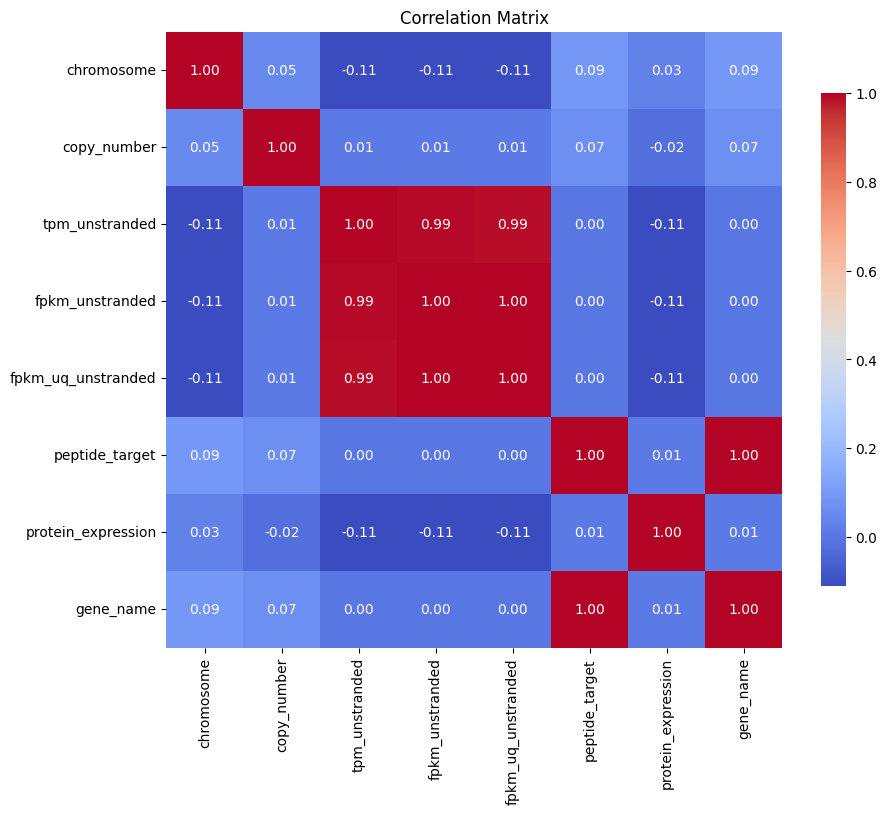

Edge Index:
[[3 4 4 7]
 [2 2 3 5]]
Edge Attributes (Weights):
[0.99426923 0.9907736  0.99783498 1.        ]


In [ ]:
edge_index,edge_attribute = GAT_pre_process(all_data_cleaned)

In [ ]:
edge_weights = edge_attribute
edge_index = torch.tensor(edge_index)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# Define the GAT model with Dimensionality Reduction (without additional attention)
class GATWithDimensionalityReduction(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, reduce_dim, num_heads=4):
        super(GATWithDimensionalityReduction, self).__init__()

        # First GATConv layer
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, edge_dim=1)

        # Second GATConv layer
        self.conv2 = GATConv(hidden_channels * num_heads, hidden_channels * 2, heads=num_heads, edge_dim=1)

        # Third GATConv layer
        self.conv3 = GATConv(hidden_channels * 2 * num_heads, hidden_channels * 4, heads=num_heads, edge_dim=1)

        # Fourth GATConv layer
        self.conv4 = GATConv(hidden_channels * 4 * num_heads, hidden_channels * 8, heads=num_heads, edge_dim=1)

        # Dimensionality reduction layer
        self.dim_reduce = nn.Linear(hidden_channels * 8 * num_heads, reduce_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(reduce_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # Final output is a single logit for each node

    def forward(self, x, edge_index, edge_attr):
        # Apply GATConv layers with activation functions
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))
        x = F.elu(self.conv4(x, edge_index))

        # Apply dimensionality reduction
        x = self.dim_reduce(x)
        x = F.elu(x)

        # Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.fc2(x)  # Final output is a single logit for each node

        return x

# Set random seeds for reproducibility
torch.manual_seed(42)

# Instantiate the model with dimensionality reduction (without attention)
in_channels = X_train_tensor.shape[1]  # Input features
hidden_channels = 8  # Number of hidden channels in GAT layers
out_channels = 16  # Output of GAT layer before reduction
reduce_dim = 32  # Dimension after reduction
num_heads = 4  # Number of attention heads

model1 = GATWithDimensionalityReduction(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, reduce_dim=reduce_dim, num_heads=num_heads)

# Define loss and optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

train_data = Data(x=X_train_tensor, edge_index=edge_index, edge_attr=edge_weights, y=y_train_tensor)

# Create PyTorch Geometric data object for testing
test_data = Data(x=X_test_tensor, edge_index=edge_index, edge_attr=edge_weights, y=y_test_tensor)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model1.train()
    optimizer.zero_grad()

    # Forward pass
    out = model1(train_data.x, train_data.edge_index, train_data.edge_attr)

    # Flatten output and calculate loss
    out = out.view(-1)
    loss = criterion(out, train_data.y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss for every 10 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Evaluate the model on the test set
model1.eval()
with torch.no_grad():
    test_out = model1(test_data.x, test_data.edge_index, test_data.edge_attr)
    test_out = test_out.view(-1)  # Flatten output
    test_loss = criterion(test_out, test_data.y)

    print(f'Test Loss: {test_loss.item():.4f}')

    # Convert logits to predictions
    predictions = torch.sigmoid(test_out)
    predicted_classes = (predictions > 0.5).float()

    # Calculate accuracy
    accuracy = (predicted_classes == test_data.y).float().mean()
    print(f'Test Accuracy: {accuracy.item() * 100:.2f}%')


Epoch [1/100], Loss: 0.694151759147644
Epoch [2/100], Loss: 0.6911205053329468
Epoch [3/100], Loss: 0.6887068152427673
Epoch [4/100], Loss: 0.6866471171379089
Epoch [5/100], Loss: 0.684893012046814
Epoch [6/100], Loss: 0.6835231781005859
Epoch [7/100], Loss: 0.6825428009033203
Epoch [8/100], Loss: 0.6816636919975281
Epoch [9/100], Loss: 0.6805436015129089
Epoch [10/100], Loss: 0.6790822148323059
Epoch [11/100], Loss: 0.6773123741149902
Epoch [12/100], Loss: 0.6753050684928894
Epoch [13/100], Loss: 0.6731552481651306
Epoch [14/100], Loss: 0.6709203720092773
Epoch [15/100], Loss: 0.6685894727706909
Epoch [16/100], Loss: 0.6661219596862793
Epoch [17/100], Loss: 0.6634993553161621
Epoch [18/100], Loss: 0.6607751250267029
Epoch [19/100], Loss: 0.6581036448478699
Epoch [20/100], Loss: 0.6557376384735107
Epoch [21/100], Loss: 0.6539619565010071
Epoch [22/100], Loss: 0.652915894985199
Epoch [23/100], Loss: 0.6523747444152832
Epoch [24/100], Loss: 0.6518430113792419
Epoch [25/100], Loss: 0.6510

In [ ]:
# Save the trained model
torch.save(model1.state_dict(), "GATWithDimensionalityReduction.pth")
print("Model saved successfully!")


Model saved successfully!


# **TESTING CODE**

In [ ]:
def readfiles(list_of_files):
  for i in list_of_files:
    if 'prote' in i:
      prote_data=pd.read_csv(i,sep='\t')
    elif 'trans' in i:
      trans_data=pd.read_csv(i,sep='\t')
    elif 'geno' in i:
      geno_data=pd.read_csv(i,sep='\t')

  return trans_data,prote_data,geno_data

In [ ]:
def preprocess(trans_data,prote_data,geno_data):
  mgt = pd.merge(geno_data, trans_data, on='gene_id', how='inner')
  ma = pd.merge(mgt, prote_data,left_on='gene_name_x', right_on='peptide_target', how='inner')
  columns=['Unnamed: 9','Unnamed: 10','gene_name_y','set_id','catalog_number','lab_id','AGID','stranded_first','stranded_second','unstranded','gene_id','start','end','min_copy_number','max_copy_number','gene_type','unstranded']
  for i in columns:
    try:
      ma = ma.drop(columns=[i])
    except:
      pass
  ma.to_csv('all_data.csv', index=False)
  all_data_cleaned = pd.read_csv('all_data.csv')
  # print(all_data_cleaned.isnull().sum())


  label_encoder = LabelEncoder()
  all_data_cleaned['gene_name'] = label_encoder.fit_transform(all_data_cleaned['gene_name_x'])
  all_data_cleaned['chromosome'] = label_encoder.fit_transform(all_data_cleaned['chromosome'])
  all_data_cleaned['peptide_target'] = label_encoder.fit_transform(all_data_cleaned['peptide_target'])
  # Prepare node features (protein expression)
  node_features = torch.tensor(all_data_cleaned['protein_expression'].values, dtype=torch.float).unsqueeze(1)
  all_data_cleaned = all_data_cleaned.drop(columns=['gene_name_x'])
  all_data_cleaned = all_data_cleaned.dropna()

  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']]  # or other relevant features
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)

  X_test1 = torch.tensor(features_scaled, dtype=torch.float32)
  return X_test1,all_data_cleaned


In [ ]:
def GAT_pre_process_for_testing(all_data_cleaned):
  features = all_data_cleaned[['chromosome','copy_number','tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded', 'peptide_target', 'protein_expression', 'gene_name']].fillna(0)
  correlation_matrix = features.corr()



  threshold = 0.8
  edges = []
  edge_attributes = []

    # Step 5: Iterate over the correlation matrix and create edges/attributes
  for i in range(len(correlation_matrix.columns)):
      for j in range(i):
          corr_value = correlation_matrix.iloc[i, j]
          if abs(corr_value) > threshold:
              # Add edge between nodes (i, j) and save the absolute correlation as the edge attribute (weight)
              edges.append([features.columns.get_loc(correlation_matrix.columns[i]),
                            features.columns.get_loc(correlation_matrix.columns[j])])
              edge_attributes.append(abs(corr_value))  # Use the absolute correlation value as the weight

    # Convert edge_index and edge_attributes to numpy arrays
  edge_index = np.array(edges).T  # Shape [2, num_edges]
  edge_attributes = np.array(edge_attributes)  # Shape [num_edges]

  return edge_index, edge_attributes

In [ ]:
list_of_files = ['/content/drive/MyDrive/Non-Cancerous/geno20.tsv','/content/drive/MyDrive/Non-Cancerous/trans20.tsv','/content/drive/MyDrive/Non-Cancerous/prote20.tsv']
trans_data_test, prote_data_test, geno_data_test = readfiles(list_of_files)
X_test1,all_data_cleaned1 = preprocess(trans_data_test,prote_data_test,geno_data_test)

edge_index, edge_attributes = GAT_pre_process_for_testing(all_data_cleaned1)
edge_weights = edge_attributes
edge_index = torch.tensor(edge_index)
test_data = Data(x=X_test1, edge_index=edge_index, edge_attr=edge_weights)

# # Create the model architecture
# model1 = GATWithDimensionalityReduction(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, reduce_dim=reduce_dim, num_heads=num_heads)

# # Load the saved state dictionary (parameters)
# model1.load_state_dict(torch.load("GATWithDimensionalityReduction.pth",weights_only=True))

# Set model to evaluation mode if you're using it for inference
model1.eval()
with torch.no_grad():
    test_out = model1(test_data.x, test_data.edge_index, test_data.edge_attr)
    test_out = test_out.view(-1)  # Flatten output

    # Convert logits to probabilities (between 0 and 1)
    probabilities = torch.sigmoid(test_out)

    # Calculate the average probability as a measure of cancer likelihood
    average_probability = probabilities.mean()

    # Convert to a percentage
    percentage_chance = average_probability.item() * 100

    # Print the percentage chance of cancer
    print(f"Percentage chance of cancer: {percentage_chance:.2f}%")



Percentage chance of cancer: 45.35%
